In [10]:
import os
import sys
import math
import time
import numpy as np
import pandas as pd
from numpy import random as npr

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from plotly import graph_objects as go
import plotly.io as pio

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['text.usetex'] = True
import datetime

In [3]:
SEED = 2021
SYNTHETC_DATASET_SIZE = 10_000
SAMPLE_SIZES = [0.1, 0.3, 0.5, 0.9]
ALPHA_SAMPLE_RATE = 20

USERPROFILE_DATASET_PATH = "/../../data/rest_data/userprofile.csv"
USERCUISINE_DATASET_PATH = "/../../data/rest_data/usercuisine.csv"
CHEFMOZCUISINE_DATASET_PATH = "/../../data/rest_data/chefmozcuisine.csv"
RATINGS_DATASET_PATH = "/../../data/rest_data/ratings_reformatted.csv"

In [ ]:
import importlib
sys.path.insert(0, r'../utilits/')

from tools import *

## Load and transform restaurants data

Helper functions 

In [3]:
def prepare_user_profile_df(df):
    df = df.drop(["latitude", "longitude"], axis=1)
    df = df.replace("?", pd.NA)
    df = df.fillna(method="bfill")
    return df


def prepare_user_cuisine_df(df):
    df.drop_duplicates()
    df = df.join(pd.get_dummies(df["Rcuisine"]))
    df = df.drop("Rcuisine", axis=1)
    df = df.groupby("userID").sum()
    return df


def load_and_clean_users_df():
    user_profile_df = pd.read_csv(USERPROFILE_DATASET_PATH)
    user_cuisine_df = pd.read_csv(USERCUISINE_DATASET_PATH)
    user_profile_df = prepare_user_profile_df(user_profile_df)
    user_cuisine_df = prepare_user_cuisine_df(user_cuisine_df)

    users_df = pd.merge(user_profile_df, user_cuisine_df, on="userID")
    return users_df


def load_and_prepare_rest_cuisine_df():
    df = pd.read_csv(CHEFMOZCUISINE_DATASET_PATH)
    df = df.drop_duplicates()
    df = df.join(pd.get_dummies(df["Rcuisine"]))
    df = df.drop("Rcuisine", axis=1)
    df = df.groupby("placeID").sum()
    return df



In [ ]:
users_df = load_and_clean_users_df()
rests_df = load_and_prepare_rest_cuisine_df()

In [6]:
ratings_df = pd.read_csv(RATINGS_DATASET_PATH)
ratings_df

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


In [7]:
merged_df = pd.merge(ratings_df, users_df, on="userID")
merged_df = pd.merge(merged_df, rests_df, on="placeID")
merged_df

,userID,placeID,rating,food_rating,service_rating,smoker,drink_level,dress_preference,ambience,transport,...,Soup_y,Southern_y,Southwestern_y,Spanish_y,Steaks_y,Sushi_y,Thai_y,Turkish_y,Vegetarian_y,Vietnamese_y
0,U1077,135085,2,2,2,false,social drinker,elegant,family,public,...,0,0,0,0,0,0,0,0,0,0
1,U1108,135085,1,2,1,false,abstemious,informal,solitary,public,...,0,0,0,0,0,0,0,0,0,0
2,U1081,135085,1,2,1,false,casual drinker,informal,family,public,...,0,0,0,0,0,0,0,0,0,0
3,U1001,135085,0,1,1,false,abstemious,informal,family,on foot,...,0,0,0,0,0,0,0,0,0,0
4,U1056,135085,2,2,2,false,social drinker,informal,family,on foot,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,U1006,132922,2,1,2,true,social drinker,no preference,friends,car owner,...,0,0,0,0,0,0,0,0,0,0
869,U1003,132937,2,2,1,false,social drinker,formal,family,public,...,0,0,0,0,0,0,0,0,0,0
870,U1027,132937,1,1,1,true,social drinker,no preference,family,public,...,0,0,0,0,0,0,0,0,0,0
871,U1029,132937,1,1,1,true,casual drinker,formal,family,public,...,0,0,0,0,0,0,0,0,0,0


In [8]:
merged_df.rating.value_counts()

2    369
1    320
0    184
Name: rating, dtype: int64

In [9]:
rests_df['placeID'] = rests_df.index
rests_df = rests_df.reset_index(drop=True)

In [10]:
users_df["userID"] = users_df["userID"].astype("category").cat.codes

Merge ratings dataset, users dataset, and restaurants dataset into single tablem

In [11]:
merged_df["userID"] = merged_df["userID"].astype("category").cat.codes
merged_df

,userID,placeID,rating,food_rating,service_rating,smoker,drink_level,dress_preference,ambience,transport,...,Soup_y,Southern_y,Southwestern_y,Spanish_y,Steaks_y,Sushi_y,Thai_y,Turkish_y,Vegetarian_y,Vietnamese_y
0,76,135085,2,2,2,false,social drinker,elegant,family,public,...,0,0,0,0,0,0,0,0,0,0
1,107,135085,1,2,1,false,abstemious,informal,solitary,public,...,0,0,0,0,0,0,0,0,0,0
2,80,135085,1,2,1,false,casual drinker,informal,family,public,...,0,0,0,0,0,0,0,0,0,0
3,0,135085,0,1,1,false,abstemious,informal,family,on foot,...,0,0,0,0,0,0,0,0,0,0
4,55,135085,2,2,2,false,social drinker,informal,family,on foot,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,5,132922,2,1,2,true,social drinker,no preference,friends,car owner,...,0,0,0,0,0,0,0,0,0,0
869,2,132937,2,2,1,false,social drinker,formal,family,public,...,0,0,0,0,0,0,0,0,0,0
870,26,132937,1,1,1,true,social drinker,no preference,family,public,...,0,0,0,0,0,0,0,0,0,0
871,28,132937,1,1,1,true,casual drinker,formal,family,public,...,0,0,0,0,0,0,0,0,0,0


In [12]:
from sdv.tabular import CTGAN, GaussianCopula, CopulaGAN
import time

def _clean_dataset(df):
    df = df.drop(["userID", "placeID"], axis=1) # Drop ids
    df = df.astype("int64", errors="ignore") # Convert all numbers to int64
    return df


def fit_and_evaluate_models(df, models, sample_size, eval_kwargs):
    result = pd.DataFrame()
    for name, model in models.items():
        start = time.time()
        model.fit(df)
        model.save('./rests_models/' + str(name) + '_' + '.pkl')
        end = time.time()
        print("Fitting of " + name)
        print(end - start)
        eval_result = evaluate(df, model.sample(sample_size), **eval_kwargs)
        eval_result["model_name"] = name
        result = pd.concat([result, eval_result])
    
    return result

In [13]:
_clean_dataset(merged_df).dtypes

rating             int64
food_rating        int64
service_rating     int64
smoker            object
drink_level       object
                   ...  
Sushi_y            int64
Thai_y             int64
Turkish_y          int64
Vegetarian_y       int64
Vietnamese_y       int64
Length: 181, dtype: object

In [14]:
df=_clean_dataset(merged_df)

In [15]:
df.isna().sum().sum()

0

## Generate synthetic data

In [ ]:
from sdv.tabular import GaussianCopula, CopulaGAN, CTGAN


def fit_syn_generator_users(df):
    model = CopulaGAN()
    df = df.drop(["userID"], axis=1) # Drop ids
    df = df.astype("int64", errors="ignore") # Convert all numbers to int64
    model.fit(df.copy())
    return model

def fit_syn_generator_rests(df):
    model = CopulaGAN()
    df = df.drop(["placeID"], axis=1) # Drop ids
    df = df.astype("int64", errors="ignore") # Convert all numbers to int64
    model.fit(df.copy())
    return model

In [13]:
npr.seed(SEED)
syn_data_generator_users = fit_syn_generator_users(users_df)
syn_data_generator_rests = fit_syn_generator_rests(rests_df)

In [15]:
npr.seed(SEED)
syn_rests_df = syn_data_generator_rests.sample(num_rows=100)
syn_rests_df.head()

,Afghan,African,American,Armenian,Asian,Bagels,Bakery,Bar,Bar_Pub_Brewery,Barbecue,...,Southern,Southwestern,Spanish,Steaks,Sushi,Thai,Turkish,Vegetarian,Vietnamese,placeID
0,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,4


In [16]:
npr.seed(SEED)
syn_users_df = syn_data_generator_users.sample(100)
syn_users_df.head()

,userID,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,...,Swiss,Tapas,Tea_House,Tex-Mex,Thai,Tibetan,Tunisian,Turkish,Vegetarian,Vietnamese
0,0,False,abstemious,no preference,solitary,public,single,independent,1992,variety,...,0,0,0,0,0,0,0,0,0,0
1,1,True,casual drinker,no preference,family,on foot,single,independent,1989,none,...,0,0,0,0,0,0,0,0,0,0
2,2,False,social drinker,informal,family,car owner,single,independent,1993,variety,...,0,0,0,0,0,0,0,0,0,0
3,3,False,abstemious,no preference,family,public,single,independent,1992,none,...,0,0,0,0,0,0,0,0,0,0
4,4,True,abstemious,formal,family,public,single,kids,1991,variety,...,0,0,0,0,0,0,0,0,0,0


In [20]:
syn_rests_df[syn_rests_df < 0] = 0

In [21]:
for col in list(syn_rests_df.columns[:-1]):
    syn_users_df.loc[syn_users_df[col] < 0, col] = 0

In [22]:
syn_users_df["userID"] = range(len(syn_users_df))
syn_rests_df["placeID"] = range(len(syn_rests_df))

## Fit DeepFM model

In [15]:
deepfm_input = merged_df.copy()
for col in deepfm_input.columns:
    deepfm_input[col] = deepfm_input[col].astype("category")

In [16]:
from deeptables.models.deeptable import DeepTable, ModelConfig
from deeptables.models import deepnets
from deeptables.datasets import dsutils
from tensorflow import keras
from deeptables.models import deeptable
from sklearn.model_selection import train_test_split

In [23]:
npr.seed(SEED)
y = deepfm_input["rating"].astype("int64")
X = deepfm_input.drop(["rating", "placeID", "userID", "food_rating", "service_rating"], axis=1)
x_train, x_tests, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

test_results = []
net = deepnets.DeepFM
conf = ModelConfig(
    nets=net, 
    optimizer=keras.optimizers.RMSprop(),
    auto_discrete=True,
    home_dir = r'../models/tmp',
    earlystopping_patience=20,
    dnn_params={
        'dnn_activation': 'relu',
    },
)

dt = deeptable.DeepTable(config=conf)
start = time.time()
model, history = dt.fit(x_train, y_train, epochs=50, batch_size=64)
end = time.time()
print('Training of DeepFM')
print(end - start)

04-25 15:16:53 I deeptables.m.deeptable.py 335 - X.Shape=(698, 178), y.Shape=(698,), batch_size=64, config=ModelConfig(name='conf-1', nets=['linear', 'fm_nets', 'dnn_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer=<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7f68bf3a20b8>, loss='auto', dnn_params={'dnn_activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True}, fg

In [30]:
score = dt.evaluate(x_tests, y_test, batch_size=64, verbose=0)
score

04-25 15:19:44 I deeptables.m.preprocessor.py 239 - Transform [X]...
04-25 15:19:44 I deeptables.m.preprocessor.py 246 - transform_X taken 0.16370058059692383s
04-25 15:19:44 I deeptables.m.preprocessor.py 227 - Transform [y]...
04-25 15:19:44 I deeptables.m.preprocessor.py 233 - transform_y taken 0.00021076202392578125s
04-25 15:19:44 I deeptables.m.deepmodel.py 169 - Performing evaluation...


{'loss': 1.0222848473276411, 'accuracy': 0.52}

In [31]:
mae = abs(dt.predict(x_tests) - y_test).mean()
mae

04-25 15:19:47 I deeptables.m.deeptable.py 661 - Perform prediction...
04-25 15:19:47 I deeptables.m.preprocessor.py 239 - Transform [X]...
04-25 15:19:47 I deeptables.m.preprocessor.py 246 - transform_X taken 0.16046905517578125s
04-25 15:19:47 I deeptables.m.deepmodel.py 142 - Performing predictions...
04-25 15:19:47 I deeptables.m.deeptable.py 540 - predict_proba taken 0.22168374061584473s
04-25 15:19:47 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.


0.6

In [ ]:
syn_users_df["_merge_key"] = syn_rests_df["_merge_key"] = 1
syn_merged_df = pd.merge(syn_users_df, syn_rests_df, on="_merge_key")
syn_merged_df = syn_merged_df.drop(["_merge_key"], axis=1)

deepfm_syn_input = syn_merged_df.copy()
for col in deepfm_syn_input.columns:
    deepfm_syn_input[col] = deepfm_syn_input[col].astype("category")

In [ ]:
df_resp = deepfm_syn_input.copy()

In [66]:
npr.seed(SEED)
resp = dt.predict(df_resp.drop(["userID", "placeID"], axis=1))

df_resp['rating'] = resp

04-07 12:33:45 I deeptables.m.deeptable.py 661 - Perform prediction...
04-07 12:33:45 I deeptables.m.preprocessor.py 239 - Transform [X]...
04-07 12:33:46 I deeptables.m.preprocessor.py 246 - transform_X taken 1.465320348739624s
04-07 12:33:46 I deeptables.m.deepmodel.py 142 - Performing predictions...
04-07 12:33:48 I deeptables.m.deeptable.py 540 - predict_proba taken 2.5504672527313232s
04-07 12:33:48 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.


In [67]:
df_resp.rating.value_counts()

2    8023
1    1957
0      20
Name: rating, dtype: int64

In [38]:
matrix = pd.DataFrame()
matrix["rating"] = df_resp['rating']
matrix["user_id"] = df_resp["userID"].astype("category").cat.codes
matrix["item_id"] = df_resp["placeID"].astype("category").cat.codes

In [39]:
mt = matrix.drop_duplicates(["user_id", "item_id"]).reset_index().drop("index", axis=1)
mt

,rating,user_id,item_id
0,1,0,0
1,2,0,1
2,2,0,2
3,1,0,3
4,0,0,4
...,...,...,...
9995,1,99,95
9996,1,99,96
9997,2,99,97
9998,2,99,98


In [40]:
mtp = mt.pivot(index="user_id", columns="item_id", values="rating")
mtp

item_id,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
0,1,2,2,1,0,1,2,2,1,1,...,1,1,1,1,1,1,0,1,2,2
1,1,2,2,1,1,1,2,2,1,1,...,1,1,1,1,1,1,1,1,2,2
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,...,2,2,1,2,2,1,1,2,2,2
4,1,2,2,1,0,0,2,2,1,1,...,1,1,0,0,0,0,0,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,2,2,2,2,2,2,2,2,2,...,2,2,1,2,2,2,2,2,2,2
96,1,2,2,1,1,1,2,2,1,1,...,1,1,1,1,1,1,1,1,2,2
97,1,2,2,1,1,1,2,2,2,1,...,1,2,1,1,1,1,1,1,2,2


## Make similarity matrix

Creating a similarity matrix between users and restaurants based on users' food preference and restaurants' cuisines.

In [22]:
from sklearn.metrics.pairwise import cosine_similarity


def make_similarity_matrix(users_df, rests_df):
    users_food_pref_df = users_df.drop(['userID', '_merge_key'], axis=1)
    rests_food_pref_df = rests_df.drop(['placeID', '_merge_key'], axis=1)
    users_food_pref_df = users_food_pref_df[rests_food_pref_df.columns]
    return cosine_similarity(users_food_pref_df, rests_food_pref_df)

In [42]:
sim_matrix = make_similarity_matrix(syn_users_df, syn_rests_df)
sim_matrix

array([[0.2236068 , 0.2236068 , 0.37796447, ..., 0.        , 0.2236068 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.4472136 , 0.37796447, ..., 0.        , 0.4472136 ,
        0.        ],
       ...,
       [0.        , 0.31622777, 0.26726124, ..., 0.        , 0.31622777,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [43]:
sim_matrix = np.where(sim_matrix < 0.33, 0, sim_matrix)
sim_matrix = np.where(sim_matrix >= 0.66, 2, sim_matrix)
sim_matrix = np.where((sim_matrix >= 0.33) & (sim_matrix < 0.66), 1, sim_matrix)
sim_matrix

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Experiments

In [3]:
import importlib
sys.path.insert(0, r'./modules/')

import evaluator, trainers, utils, models
importlib.reload(models)
importlib.reload(trainers)
importlib.reload(evaluator)
importlib.reload(utils)

<module 'utils' from './modules/utils.py'>

In [4]:
class ResponseFunction:
    def __init__(self, heu_matrix, nn_matrix, noise_matrix):
        assert heu_matrix.shape == nn_matrix.shape
        self._heu_matrix = heu_matrix
        self._nn_matrix = nn_matrix
        self._noise_matrix = noise_matrix
        
    def __call__(self, a1: float, a2: float):
        a3 = max(0.0, 1 - a1 - a2)
        
        return (
            a1 * self._heu_matrix
            + a2 * self._nn_matrix
            + a3 * npr.normal(1, 1, size=self._heu_matrix.shape)
            #to avoid identical zeros in NMF
            + 0.00001
        )    

# Real-Syn Comparison

## Real Data

In [35]:
real_sample = deepfm_input.sample(n=100)[['userID', 'placeID', 'rating']]

In [34]:
print('Users: ', len(real_sample.userID.unique()))
print('Items: ', len(real_sample.placeID.unique()))
print('Pairs: ', 100)

print('Dense: ', 100/(len(real_sample.userID.unique()) * len(real_sample.placeID.unique())))

Users:  70
Items:  60
Pairs:  100
Dense:  0.023809523809523808


In [56]:
real_results = pd.DataFrame()

for num in range(1, 11):
    real_sample = deepfm_input.sample(n=100)[['userID', 'placeID', 'rating']]
    real_sample.rating = real_sample.rating.astype('float')
    matrix = pd.DataFrame()
    matrix["user_id"] = real_sample["userID"].astype("category").cat.codes
    matrix["item_id"] = real_sample["placeID"].astype("category").cat.codes
    matrix["rating"] = real_sample["rating"]
    
    mt = matrix.drop_duplicates(["user_id", "item_id"]).reset_index().drop("index", axis=1)
    mtp = mt.pivot(index="user_id", columns="item_id", values="rating")
    
    _resp_fn_config = evaluator.ResponseFunctionConfig(
    factory=ResponseFunction,
    args=[mtp, mtp, mtp]
    )
    
    _evaluators = [
    
    evaluator.TrainTestExecutorConfig(
        factory=trainers.NmfTrainTestExecutor,
        args={},
        model_name="nmf"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.SvdTrainTestExecutor,
        args={},
        model_name="svd"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.KnnTrainTestExecutor,
        args={},
        model_name="knn"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.AutoRecTrainTestExecutor,
        args={},
        model_name="autorec"
    ) 
    ]
    
    np.random.seed(SEED)
    _evaluator = evaluator.Evaluator(_resp_fn_config, n_proc=4)

    results = _evaluator.evaluate(
        _evaluators, 
        a_sample_rate=2,
        test_size=0.2, 
        sample_sizes=[0.1, 0.3, 0.5, 0.9]
    )
    
    real_results = real_results.append(results)

Subprocess started.Subprocess started.Subprocess started.


RMSE: 0.6745RMSE: 0.5590RMSE: 0.0871


MAE:  0.5259MAE:  0.5000MAE:  0.0862


RMSE: 0.6576RMSE: 0.6009RMSE: 0.5412


MAE:  0.5956MAE:  0.5000MAE:  0.4190


RMSE: 0.5223RMSE: 0.9932RMSE: 0.7620


MAE:  0.3981MAE:  0.7100MAE:  0.6647


RMSE: 0.5649
MAE:  0.4368
RMSE: 0.9401RMSE: 0.7840RMSE: 1.0308


MAE:  0.7933MAE:  0.6929MAE:  1.0000


RMSE: 0.4836
MAE:  0.4227RMSE: 0.6922

MAE:  0.5833
RMSE: 0.5765
MAE:  0.5168
RMSE: 0.4954
MAE:  0.4388
RMSE: 0.4759
MAE:  0.4018
RMSE: 0.7307
MAE:  0.6432
RMSE: 0.5699
MAE:  0.4871
RMSE: 1.0000
MAE:  1.0000
RMSE: 0.4877
MAE:  0.4028
RMSE: 1.0247
MAE:  0.9000
RMSE: 0.8217
MAE:  0.7170
Subprocess started.Subprocess started.Subprocess started.


RMSE: 0.0871RMSE: 0.5590RMSE: 0.6745


MAE:  0.5000MAE:  0.0862MAE:  0.5259


RMSE: 0.8770RMSE: 0.8782RMSE: 0.7303


MAE:  0.7473MAE:  0.7447MAE:  0.5693


RMSE: 0.6584
RMSE: 1.0561MAE:  0.5936

MAE:  0.9558
RMSE: 0.6509
MAE:  0.5236
RMSE: 0.8124
RMSE: 0.8

## Syn Data

In [62]:
syn_results = pd.DataFrame()

for num in range(1, 11):

    syn_rests_df = syn_data_generator_rests.sample(num_rows=100)
    syn_users_df = syn_data_generator_users.sample(100)
        
    syn_users_df["_merge_key"] = syn_rests_df["_merge_key"] = 1
    syn_merged_df = pd.merge(syn_users_df, syn_rests_df, on="_merge_key")
    syn_merged_df = syn_merged_df.drop(["_merge_key"], axis=1)
    
    deepfm_syn_input = syn_merged_df.copy()
    
    df_resp = deepfm_syn_input.sample(frac=0.022962112514351322)
    df_resp_no = deepfm_syn_input.drop(df_resp.index)

    npr.seed(SEED)
    resp = dt.predict(df_resp.drop(["userID", "placeID"], axis=1))
    df_resp['rating'] = resp
    df_resp_no['rating'] = np.asarray([np.nan for i in range(df_resp_no.shape[0])])
    df_full = pd.concat([df_resp, df_resp_no])

    matrix = pd.DataFrame()
    matrix["rating"] = df_full['rating']
    matrix["user_id"] = df_full["userID"].astype("category").cat.codes
    matrix["item_id"] = df_full["placeID"].astype("category").cat.codes
    
    mt = matrix.drop_duplicates(["user_id", "item_id"]).reset_index().drop("index", axis=1)
    mtp = mt.pivot(index="user_id", columns="item_id", values="rating")
    
    _resp_fn_config = evaluator.ResponseFunctionConfig(
    factory=ResponseFunction,
    args=[mtp, mtp, mtp]
    )
    
    _evaluators = [
    
    evaluator.TrainTestExecutorConfig(
        factory=trainers.NmfTrainTestExecutor,
        args={},
        model_name="nmf"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.SvdTrainTestExecutor,
        args={},
        model_name="svd"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.KnnTrainTestExecutor,
        args={},
        model_name="knn"
    ),
    evaluator.TrainTestExecutorConfig(
        factory=trainers.AutoRecTrainTestExecutor,
        args={},
        model_name="autorec"
    ) 
    ]
    
    np.random.seed(SEED)
    _evaluator = evaluator.Evaluator(_resp_fn_config, n_proc=4)

    results = _evaluator.evaluate(
        _evaluators, 
        a_sample_rate=2,
        test_size=0.2, 
        sample_sizes=[0.1, 0.3, 0.5, 0.9]
    )
    
    syn_results = syn_results.append(results)

Subprocess started.Subprocess started.Subprocess started.


RMSE: 0.2758RMSE: 0.5049RMSE: 0.5622


MAE:  0.2056MAE:  0.4788MAE:  0.4556


RMSE: 1.0392RMSE: 0.4337RMSE: 0.6253


MAE:  0.9267MAE:  0.4141MAE:  0.5515


RMSE: 0.4951RMSE: 1.0940RMSE: 0.6650


MAE:  0.4405MAE:  0.9367MAE:  0.5639


RMSE: 0.6608
MAE:  0.5199
RMSE: 0.5199RMSE: 1.2790

MAE:  0.4357MAE:  0.9244

RMSE: 0.4900
MAE:  0.4778
RMSE: 0.4799
MAE:  0.4073
RMSE: 0.4499
MAE:  0.4129
RMSE: 0.3782
MAE:  0.3300
RMSE: 0.4742
MAE:  0.4135
RMSE: 0.4793
MAE:  0.3897
RMSE: 0.4560
MAE:  0.3779
RMSE: 0.6488
MAE:  0.5132
RMSE: 0.6921
MAE:  0.5778
RMSE: 0.4569
MAE:  0.4346
RMSE: 0.4942
MAE:  0.4378
RMSE: 0.4394
MAE:  0.3795
Subprocess started.Subprocess started.Subprocess started.


RMSE: 0.2939RMSE: 0.5622RMSE: 0.5159


MAE:  0.2211MAE:  0.4788MAE:  0.4573


RMSE: 0.5483RMSE: 0.4783RMSE: 0.8972


MAE:  0.4491MAE:  0.7316MAE:  0.4484


RMSE: 0.4963
MAE:  0.3999
RMSE: 0.9310RMSE: 0.4398

MAE:  0.6815MAE:  0.4326

RMSE: 0.5949
MAE:  0.5

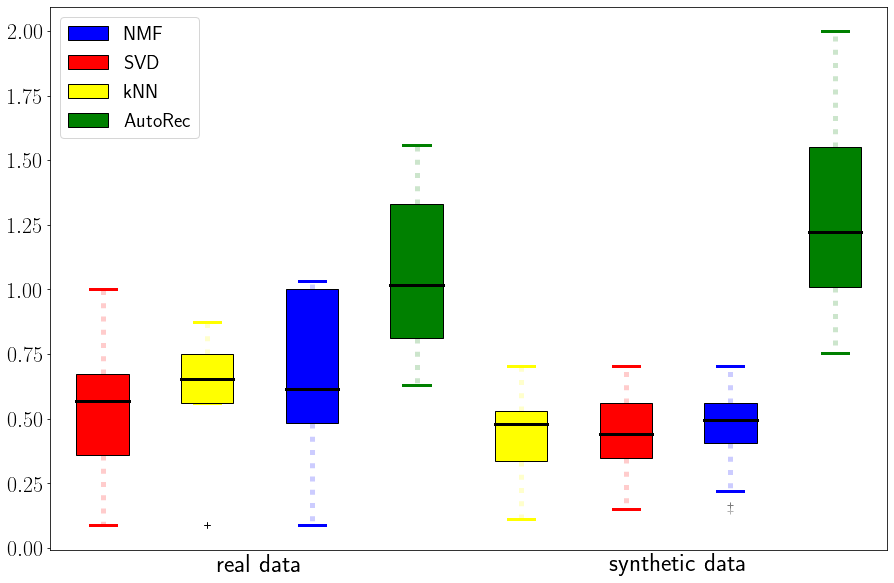

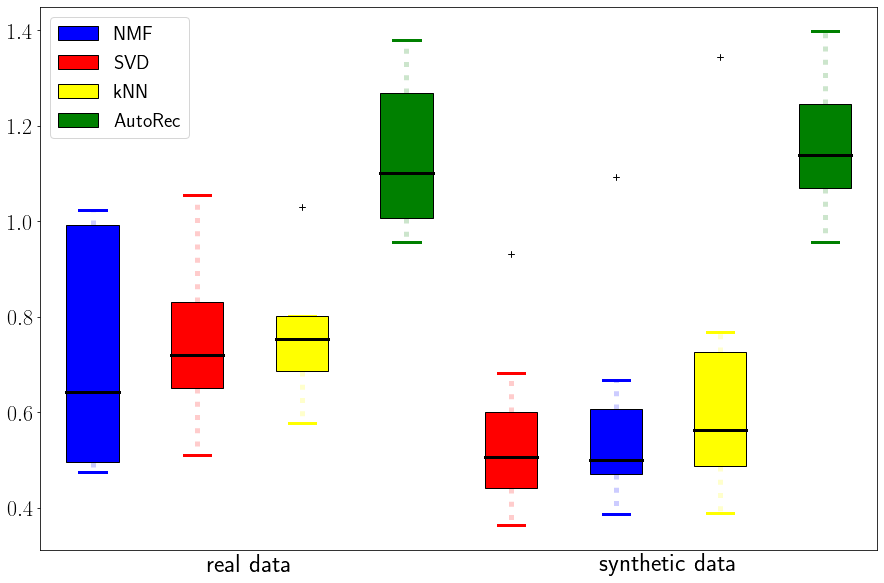

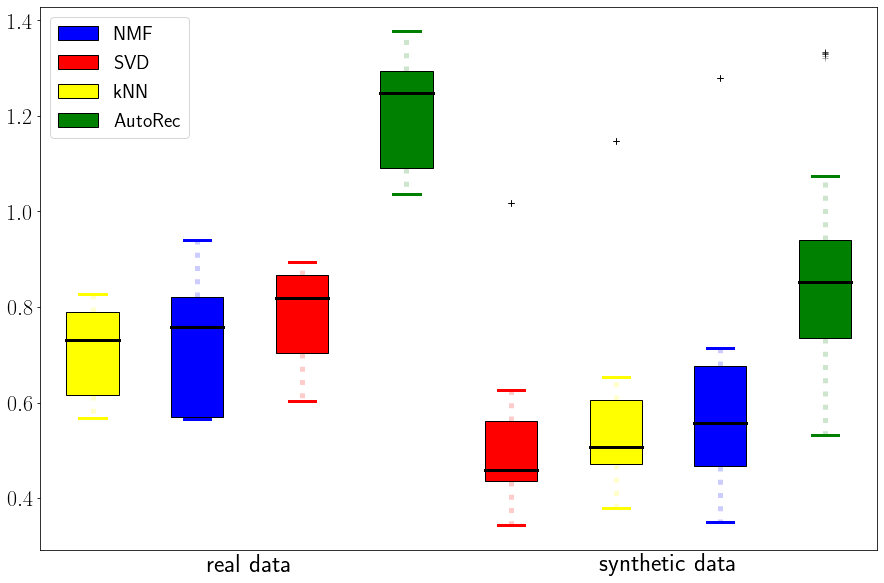

In [24]:
real = real_results
syn = syn_results

boxplot(real[real.sample_size==0.1], syn[syn.sample_size==0.1], legend_loc='upper left')

boxplot(real[real.sample_size==0.5], syn[syn.sample_size==0.5], legend_loc='upper left')

boxplot(real[real.sample_size==0.9], syn[syn.sample_size==0.9], legend_loc='upper left')